# **About this Dataset**

This project analyzes a dataset obtained from **Northeastern University’s Affective and Brain Sciences Lab**, in which thirty participants in a **functional Magnetic Resonance Imaging (fMRI) scanner** were shown images that elicit anger, fear, or disgust after being primed with
congruent, incongruent, or neutral emotion words. Congruent emotion words are words that are consistent emotionally to the image shown; being primed with an angry word and shown an angry image is considered congruent priming. Being shown a fearful word and then disgusting image is considered incongruent priming. Being shown a neutral word and a fearful image is considered neutral priming.

The images are **preprocessed three-dimensional beta maps**, where the value at each voxel is representative of the participant’s level of **brain activity** during this task. fMRI data provides dimensions for time of scan acquisition, location coordinates of a voxel within the brain, and brain activation intensity values.

### **In Summary...**

- 270 beta maps → 30 subjects × 3 emotions × 3 priming conditions
- Each map is 3D (91 × 109 × 91), encoding voxelwise brain activation
- Each subject has 9 trials (one per emotion × priming combo)
- Labels: Emotion (3 classes), Priming (3 classes), Subject ID (30)

# **Research Objective**

1. Can brain activation patterns predict emotional response categories (anger, fear, disgust)?
2. How does priming condition (congruent, incongruent, neutral) modulate brain responses to emotion?
3. Do individuals show consistent patterns of emotion-related brain activation regardless of emotion state or priming condition? 
4. What regions are most predictive of each emotion?
5. Does congruency in visual and auditory (priming words) information affect brain activity? And is there more consistency when both primings are equivalent?
6. What classification model can most accurately predict emotion? Priming condition? Subject?
7. What dimensionality reduction technique, statistical or neurological parcellation, is the best approach for classifier performance?


In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import nibabel as nib
from nilearn import input_data, plotting
from nilearn import datasets as ni_data
from nilearn.image import get_data
import numpy as np
import os
import pandas as pd
from scipy import stats
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding, TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets as torch_data

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# **Load Data**

Because of the size of the data, I have stored it into a hugging face dataset and load it directly onto my computer. In the future, I will restructure the code to support streaming the data rather than directly storing onto my local machine due to the size of 270 .niigz files. 

In [4]:
def create_file_list(subs, emotions, primings):
    '''
    purpose: create lists for file names, specified subjects, emotion states and priming conditions
    
    parameters:
        subs: list: subject numbers
        emotions: list: emotion states (anger, fear, disgust)
        priming: list: of priming conditions (congruent,, incongruent, neutral)
    
    output: 
        files (list): list of file names
        subject_no (list): list of subject numbers matching the order of the file names
        emotion_class (list): list of emotion states matching the order of the file names
        priming_class (list): list of priming conditions matching the order of the file names
        
    '''

    # intialize vars
    files = []
    subject_no = []
    emotion_class = []
    priming_class = []

    # iterate over the different classes
    for sub in subs:
        for emo in emotions: 
            for priming in primings:
    
                # get the subject as a string
                if sub // 10 == 0:
                    sub_str = '00' + str(sub)
                else:
                    sub_str = '0' + str(sub)
                
                # create the filename and add to list
                filename = './emotion-fmri-neu/cp' + sub_str + '_beta_' + emo + '_' + priming + '_c0.nii.gz'
                files.append(filename)
                subject_no.append(sub)
                emotion_class.append(emo)
                priming_class.append(priming)

    return files, subject_no, emotion_class, priming_class

In [5]:
def create_dataset(files):
    '''
    purpose: generate dataset of image_da tuple of file names, specified subjects, emotion states and priming conditions
    
    parameters:
        none
    
    output: 
        image_data: np.array: 4D array of voxel brain data for 270 test subjects
    '''

    # convert image data to NumPy array
    image_list = []

    for f in files:
        img = nib.load(f)
        data = img.get_fdata()
        image_list.append(data)

    # stack all into one 4D array: (270, 91, 109, 91)
    image_data = np.stack(image_list)

    return image_data

In [6]:
# create lists for classes and filenames
subjects = range(1,31)
emotions = ['anger', 'fear', 'disgust']
primings = ['congruent', 'incongruent', 'neutral']
files, subject_no, emotion_class, priming_class = create_file_list(subjects, emotions, primings)

# load raw data as numpy arrays
image_data  = create_dataset(files)

# output dimension to understand underlying data structure
image_data.shape

(270, 91, 109, 91)

## **Create Directories to Load Future Data Into**

In [126]:
directories = [ 'data', './data/parcellations', 'visualizations', './visualizations/cost_functions', './visualizations/heatmaps',
               './data/vif_dataframes', './visualizations/atlas_maps', './data/two-dimensions', 
               './visualizations/hev_violinplots', './visualizations/two-dimensions',
              ]

for dir_name in directories:
    try:
        os.mkdir(dir_name)
        print(f"Directory '{dir_name}' created successfully.")
    except FileExistsError:
        print(f"Directory '{dir_name}' already exists.")
    except PermissionError:
        print(f"Permission denied: Unable to create '{dir_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

Directory 'data' already exists.
Directory './data/parcellations' created successfully.
Directory 'visualizations' already exists.
Directory './visualizations/cost_functions' already exists.
Directory './visualizations/heatmaps' already exists.
Directory './data/vif_dataframes' already exists.
Directory './visualizations/atlas_maps' already exists.
Directory './data/two-dimensions' already exists.
Directory './visualizations/hev_violinplots' already exists.
Directory './visualizations/two-dimensions' already exists.


# **Feature Extraction**

As you can see our input data is 4D of size 270 x 91 x 109 x 91. This input is far **too large** (243,709,830 numerical values, 902,629 per sample) to feed into a classifier. To reduce the **computational complexity**, multiple **dimensionality reduction** and **brain parcellation** techniques will be applied to reduce each fMRI image to important features. Each dimension reduction technique will reduce each image to 20 - 23 features. 

## **Brain Parcellation Techniques**

* Harvard_Oxford cort 0 x 1: 48 features
* Harvard_Oxford cortl 0 x 1: 96 features
* Harvard_Oxford sub 0 x 1: 21 features
* Juelich 0 x 1: 62 features
* AAL SPM12: 116 features
* Talairach Hemi x Lobe x Tissue: 22 features
    * Talairach Hemi: 7
    * Talairach Lobe: 12
    * Talairach Tissue: 3
* Talairach Gyrus: 55 features
* Talairach Ba: 71 features
* Schaefer 100 x 7 x 1: 100 features

In [7]:
def parcellation_atlas_dict():
    
    '''
    purpose: create a dictionaries for all parcellation techniques with their respective maps and labels
    parameters: none
    output: 
        tuple: 
            maps: dict: brain parcellation atlas maps in the NiLearn dataset  
            regions: dict: brain regions correlated to each map  
    '''

       # Harvard Oxford Atlases
    harvard_oxford_cort_0_1 = ni_data.fetch_atlas_harvard_oxford('cort-maxprob-thr0-1mm')
    harvard_oxford_cortl_0_1 = ni_data.fetch_atlas_harvard_oxford('cortl-maxprob-thr0-1mm')
    harvard_oxford_sub_0_1 = ni_data.fetch_atlas_harvard_oxford('sub-maxprob-thr0-1mm')

    # Juelich Atlas
    juelich_0_1 = ni_data.fetch_atlas_juelich('maxprob-thr0-1mm')

    # AAL templates
    aal_spm12 = ni_data.fetch_atlas_aal('SPM12')

    # Talairach atlases
    talairach_hemi = ni_data.fetch_atlas_talairach('hemisphere')
    talairach_lobe = ni_data.fetch_atlas_talairach('lobe')
    talairach_gyrus = ni_data.fetch_atlas_talairach('gyrus')
    talairach_tissue = ni_data.fetch_atlas_talairach('tissue')
    talairach_ba = ni_data.fetch_atlas_talairach('ba')

    # Schaefer 2018 atlas
    schaefer_100_7_1 = ni_data.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=1)

    maps = {
              'Harvard_Oxford cort 0 x 1': harvard_oxford_cort_0_1.maps, 'Harvard_Oxford cortl 0 x 1': harvard_oxford_cortl_0_1.maps,
              'Harvard_Oxford sub 0 x 1': harvard_oxford_sub_0_1.maps, 'Juelich 0 x 1' : juelich_0_1.maps, 'AAL SPM12' : aal_spm12.maps,
               'Talairach Hemi' : talairach_hemi.maps, 'Talairach Lobe' : talairach_lobe.maps, 'Talairach Gyrus' : talairach_gyrus.maps,
               'Talairach Tissue' : talairach_tissue.maps, 'Talairach Ba' : talairach_ba.maps,
              'Schaefer 100 x 7 x 1' : schaefer_100_7_1.maps,
            }


    regions = {
              'Harvard_Oxford cort 0 x 1': harvard_oxford_cort_0_1.labels, 'Harvard_Oxford cortl 0 x 1': harvard_oxford_cortl_0_1.labels,
              'Harvard_Oxford sub 0 x 1': harvard_oxford_sub_0_1.labels, 'Juelich 0 x 1' : juelich_0_1.labels, 'AAL SPM12' : aal_spm12.labels,
               'Talairach Hemi' : talairach_hemi.labels, 'Talairach Lobe' : talairach_lobe.labels, 'Talairach Gyrus' : talairach_gyrus.labels,
               'Talairach Tissue' : talairach_tissue.labels, 'Talairach Ba' : talairach_ba.labels,
              'Schaefer 100 x 7 x 1' : schaefer_100_7_1.labels,
            }

    return maps, regions


In [8]:
def parcellized_brain_vecs(brain_imgs, parc_map, atlas):
    '''
    purpose: transform each .nii.gz image into a 1D vector using brain parcellation techniques
    
    params:
        brain_img: list: filenames for fMRI data
        parc_map : dict: dictionary of parcellation atlas maps
        atlas : str: name of brain parcellation technique

    
    output: np.array: transformed data based on input parcellation technique
    '''
    
    masker = input_data.NiftiLabelsMasker(labels_img=parc_map[atlas])
    features = masker.fit_transform(brain_imgs)
    
    return features

In [9]:
# create datasets for each brain parcellation
maps, regions = parcellation_atlas_dict()

In [ ]:
# save data as csv files to decrease loading time when kernel dies

for key in maps.keys():
    data = parcellized_brain_vecs(files, maps, key)

    # skip parcellation label 'Background'
    if (key == 'AAL SPM12') or (key == 'Schaefer 100 x 7 x 1'):
        names = regions[key]
    else:
        names = regions[key][1:]
    df = pd.DataFrame(data, columns=names)
    df['filename'] = files
    df['subject'] = subject_no
    df['emotion'] = emotion_class
    df['priming'] = priming_class
    df.to_csv(f'./parcellations/{key}.csv', index=False)

## **Dimensionality Reduction**

* PCA
* Sammon Mapping
* Isomap
* Modified Locally Linear Kernel
* Hessian Eigenmapping
* Multi-dimensional Scaling
* Autoencoder
* tSNE

Unlike the brain parcellation maps that have predetermined number of features based on specific areas of the brain, statistical methods like explained variance and stress functions must be used to determine the appropriate number of components for the following dimensionality reduction methods.

In dimensionality reduction methods, especially PCA, if N < D where N = number of data samples and D = number of input features, then  the linear subspace diminesaility is at most N-1 which in this example is 269. 269 is likely not the optimizied number of components for each dimensionality reduction. This is where approaches such as explained variance for PCA and stress function minimization for Sammon Mapping come into play. 






In [8]:
# reshape and scale data from 4D to 2D to simplify dim redux operations
X = StandardScaler().fit_transform(image_data.reshape(270, -1))
X.shape

(270, 902629)

### **Principal Component Analysis**

Best practice for PCA is that the number of components is reduced to the minimum number necessary to explain 99% of variance.

Which in this case is **226 components**. Below you can see where the curve meets the horizontal line at the 0.99 threshold.

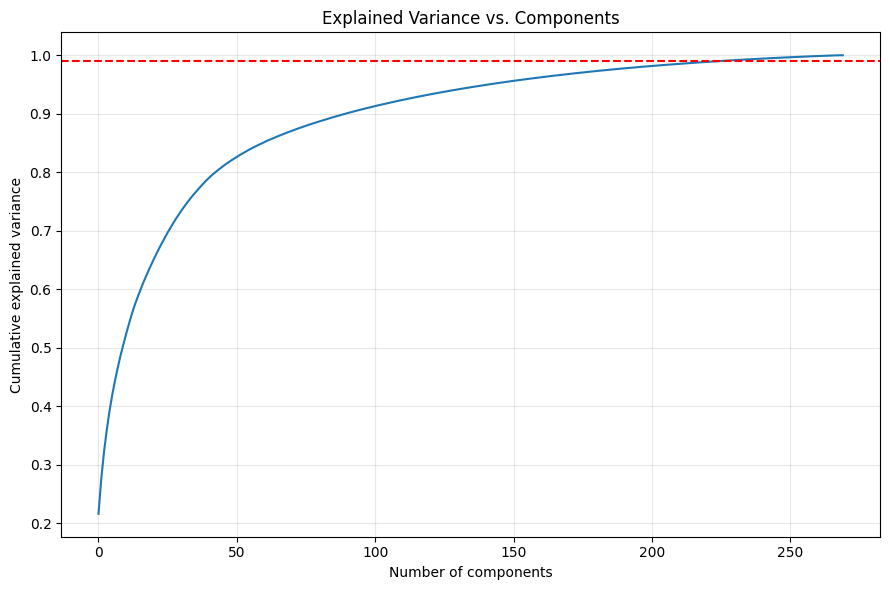

Number of components to explain 99% of variance: 226


In [18]:
# fit PCA model
pca = PCA()
X_test_pca = pca.fit_transform(X)

# get cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(9, 6))
plt.plot(cumulative_variance)
plt.axhline(y=0.99, color='r', linestyle='--')

plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained Variance vs. Components')


plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

# find the number of components that reach 99% variance
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
print(f"Number of components to explain 99% of variance: {n_components_99}")

In [9]:
# PCA dim reduction with 226 components
pca_dim_redux = PCA(n_components=226)
X_pca = pca_dim_redux.fit_transform(X)

## **Stress Functions and Reconstruction Errors**

The remaining dimensionality reduction methods, use cost functions to assess the information loss from dimension reduction. Iteratively, I looked at the rate of change per component (visually) for a plateau (elbow) where the rate at which the error decreases per additional component is statistically negligible. The componuent count for each method at the elbow will be the number of components used for that method.

In [ ]:
def sammon_mapping(x, n = 2, display = 0, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'pca'):
    '''from open source contirbutor: https://pypi.org/project/sammon-mapping'''
    
    X = x

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        xD = X
    else:
        xD = cdist(X, X)

    # Remaining initialisation
    N = X.shape[0] # hmmm, shape[1]?
    scale = 0.5 / xD.sum()

    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(X)
        Y = UU[:,:n]*DD[:n] 
    else:
        Y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])

    xD = xD + np.eye(N)        
    xDinv = 1 / xD # Returns inf where D = 0.
    xDinv[np.isinf(xDinv)] = 0 # Fix by replacing inf with 0 (default Matlab behaviour).    
    yD = cdist(Y, Y) + np.eye(N)
    yDinv = 1. / yD # Returns inf where d = 0. 
    
    np.fill_diagonal(xD, 1)    
    np.fill_diagonal(yD, 1)
    np.fill_diagonal(xDinv, 0)
    np.fill_diagonal(yDinv, 0)
    
    xDinv[np.isnan(xDinv)] = 0
    yDinv[np.isnan(xDinv)] = 0
    xDinv[np.isinf(xDinv)] = 0    
    yDinv[np.isinf(yDinv)] = 0 # Fix by replacing inf with 0 (default Matlab behaviour).
    
    delta = xD - yD 
    E = ((delta**2)*xDinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = yDinv - xDinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta, Y) - (Y * deltaone)
        dinv3 = yDinv ** 3
        y2 = Y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2, Y) * np.dot(dinv3, Y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old = Y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = s.reshape(2,round(len(s)/2)).T
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d # Returns inf where D = 0. 
            dinv[np.isinf(dinv)] = 0 # Fix by replacing inf with 0 (default Matlab behaviour).
            delta = xD - d
            E_new = ((delta**2)*xDinv).sum()
            if E_new < E:
                break
            else:
                s = np.dot(0.5,s)

        # Bomb out if too many halving steps are required
        if j == maxhalves:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if np.abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = ' + str(i) + ': E = ' + str(E * scale))

    # Fiddle stress to match te original Sammon paper
    E = E * scale
    
    return y,E

In [62]:
def plot_cost_function_per_component(model, input_data, max_dims=269):

    # initalize error list for plotting
    errors = {}
    
    # iterate over each component count to see when error stop decreasing significantly
    for d in range(1, max_dims, 10):
        print(f'Round: {d}')

        try:

            if model == 'sammon':
                output, E = sammon_mapping(input_data, d)
                errors[d] = E
    
            elif model == 'isomap':
                isomap = Isomap(n_components=d, n_neighbors=10)
                X_iso = isomap.fit_transform(input_data)
                E = isomap.reconstruction_error()
                errors[d] = E
    
            elif model == 'mlle':
                embedding = LocallyLinearEmbedding(n_components=d, method='modified', n_neighbors = d * 2)
                X_transformed = embedding.fit_transform(input_data)
                E = embedding.reconstruction_error_
                errors[d] = E
    
            elif model == 'hessian':
                embedding = LocallyLinearEmbedding(n_components=d, method='hessian', n_neighbors = int(d * (d + 4) / 2))
                X_transformed = embedding.fit_transform(input_data)
                E = embedding.reconstruction_error_
                errors[d] = E
    
            elif model == 'mds':
                mds = MDS(n_components=d, dissimilarity='euclidean', normalized_stress='auto')
                X_mapped = mds.fit_transform(input_data)
                E = mds.stress_
                errors[d] = E

        
        except ValueError as e:
            print(f"Skipped d={d}: {e}")
            continue

        
        # add error to cost function list
        


    # plot to see "elbow"
    plt.figure(figsize=(9, 6))
    keys = list(errors.keys())
    vals = list(errors.values())
    plt.plot(keys, vals)
    
    plt.xlabel('Number of components')
    plt.ylabel('Error')
    plt.title('Cost Function vs. Components')
    
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

### **Sammon Mapping**

The runtime for sammon mapping was taking long and kept crashing my kernel so I decided to leave it out of the analysis.

### **Isomap**

For isomap we can use reconstruction error, the cost function which can help us see when there is no longer a dramatic decreases in error as we increase component count. to 

Round: 1
Round: 11
Round: 21
Round: 31
Round: 41
Round: 51
Round: 61
Round: 71
Round: 81
Round: 91
Round: 101
Round: 111
Round: 121
Round: 131
Round: 141
Round: 151
Skipped d=151: There are significant negative eigenvalues (0.000294068 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.
Round: 161
Skipped d=161: There are significant negative eigenvalues (0.0013739 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.
Round: 171
Skipped d=171: There are significant negative eigenvalues (0.00256321 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.
Round: 181
Skipped d=181: There are significant negative eigenvalues (0.00432735 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the ma

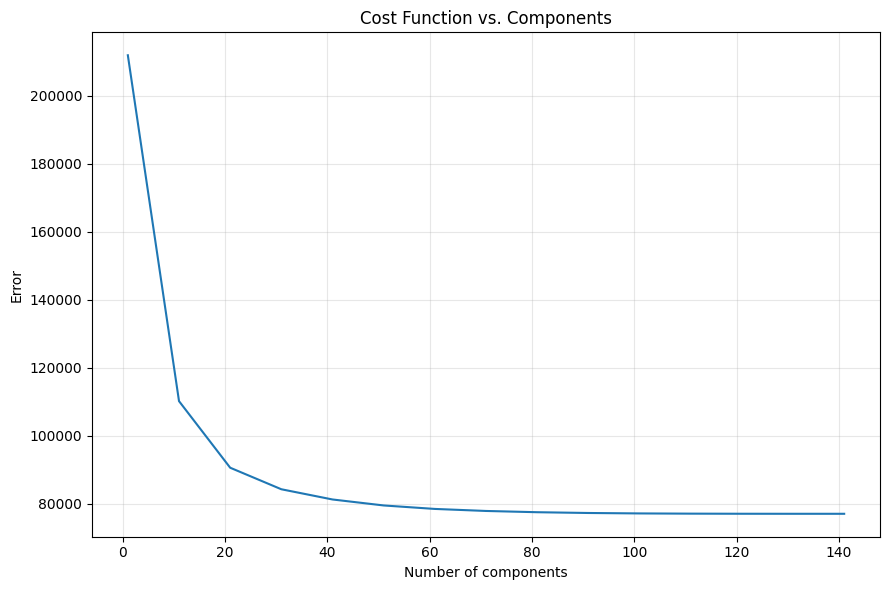

In [63]:
plot_cost_function_per_component('isomap', X)

In [10]:
# Isomap dim reduction with 51 components
isomap_dim_redux = Isomap(n_components=51, n_neighbors=10)
X_isomap = isomap_dim_redux.fit_transform(X)

/Users/anandafrancis/opt/anaconda3/lib/python3.8/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


### **Modified Locally Linear Embedding**

The runtime for sammon mapping was taking long and kept crashing my kernel so I decided to leave it out of the analysis.

### **t-SNE**

t-SNE cannot expand beyond more than 3 dimensions so that is the maximum set here. 

In [11]:
X_tsne = TSNE(n_components=3, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

### **Autoencoders**

The runtime for sammon mapping was taking long and kept crashing my kernel so I decided to leave it out of the analysis.

In [87]:
class Autoencoder(nn.Module):
    """Autoencoder implementation using PyTorch"""
    def __init__(self, input_dim, latent_dim=2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)

In [88]:
def train_autoencoder(X, input_dim, latent_dim=2, epochs=50, batch_size=128):
    """Train autoencoder and return latent representations"""
    model = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    #Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X)
    dataset = torch.utils.data.TensorDataset(X_tensor, X_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    #Training loop
    for epoch in range(epochs):
        for batch_features, _ in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            loss.backward()
            optimizer.step()
    
    #Get latent representations
    with torch.no_grad():
        latent = model.encode(X_tensor).numpy()
    
    return latent

### **Hessian Eigenmapping**

In [12]:
def quadratic_formula(a, b, c):
    return (-b + ((b**2 - 4*a*c) **0.5)) / 2*a

In [13]:
d = quadratic_formula(1, 3, -540)
int(21 * (21 + 4) / 2), d

(262, 21.786262044390035)

In [ ]:
# Hessian Eigenmapping dim reduction with 21 components
hessian_dim_redux = LocallyLinearEmbedding(n_components=21, method='hessian', n_neighbors=262)
X_hessian= hessian_dim_redux.fit_transform(X)

### **Multi-dimesional Scaling**



Round: 1
Round: 11
Round: 21
Round: 31
Round: 41
Round: 51
Round: 61
Round: 71
Round: 81
Round: 91
Round: 101
Round: 111
Round: 121
Round: 131
Round: 141
Round: 151
Round: 161
Round: 171
Round: 181
Round: 191
Round: 201
Round: 211
Round: 221
Round: 231
Round: 241
Round: 251
Round: 261


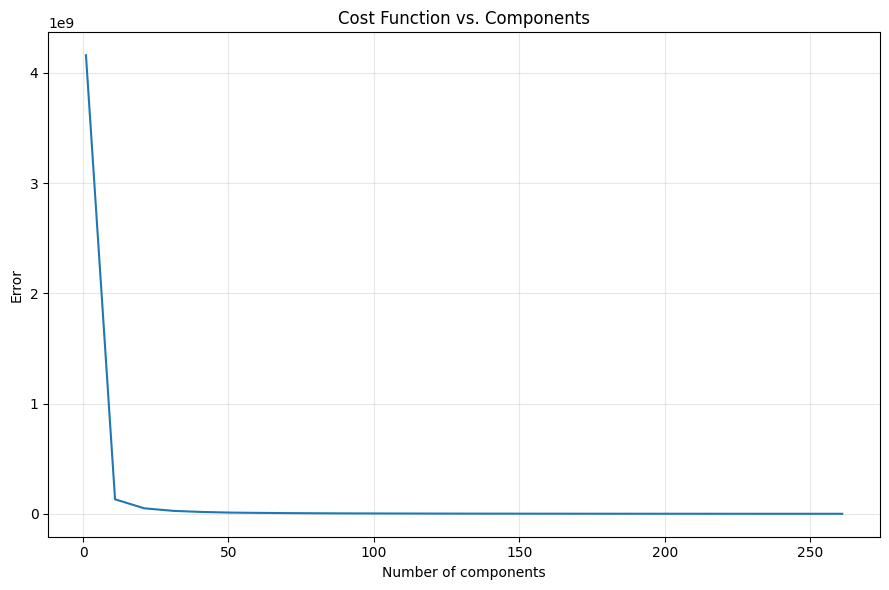

In [64]:
plot_cost_function_per_component('mds', X)

In [ ]:
# MDS dim reduction with 40 components
mds_dim_redux = MDS(n_components=40, dissimilarity='euclidean', normalized_stress='auto')
X_mds = mds_dim_redux.fit_transform(X)

In [ ]:
# load data from csv files to save time
X_pca = pd.read_csv('./dimension_reductions/{key}.csv'

In [15]:
# create dictionary for datasets of each dimension reduction method
dimension_redux_dict = {'PCA': X_pca, 'Isomap': X_isomap, 'Hessian': X_hessian, 'MDS': X_mds, 't-SNE': X_tsne
                        # 'Sammon': X_sam, 'MLLE': X_mlle, 'Autoencoder': X_ae 
                       }
dim_redux_methods = dimension_redux_dict.keys()

In [ ]:
# save data as csv files to decrease loading time when kernel dies
directory_name = 'dimension_reductions'

try:
    os.mkdir(directory_name)
    print(f"Directory '{directory_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{directory_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")


for key in dim_redux_methods:
    data = dimension_redux_dict[key]
    names = [f'Feat {i+1}' for i in range(len(data.T))]
    df = pd.DataFrame(data, columns=names)
    df['filename'] = files
    df['subject'] = subject_no
    df['emotion'] = emotion_class
    df['priming'] = priming_class
    df.to_csv(f'./dimension_reductions/{key}.csv', index=False)

In [ ]:
dim_redux_methods = ['PCA', 'Isomap', 'Hessian', 'MDS', 't-SNE']

brain_parcellations = {key: pd.read_csv(f'./parcellations/{key}.csv') for key in maps.keys()}

# **Exploratory Data Analysis**

## **Multicollinearity for Brain Parcellation**

In [ ]:
# make this 1 dataset instead of 3 due to the very low dimesnional input space: & + 3 + 12 = 22 features
brain_parcellations['Talairach Hemi x Lobe x Tissue'] = pd.concat([ 
                                          brain_parcellations['Talairach Hemi'], 
                                          brain_parcellations['Talairach Lobe'], 
                                          brain_parcellations['Talairach Tissue'] 
                                        ], axis=1)

brain_parcellations['Talairach Hemi x Lobe x Tissue'].to_csv('./parcellations/Talairach Hemi x Lobe x Tissue.csv', index=False)

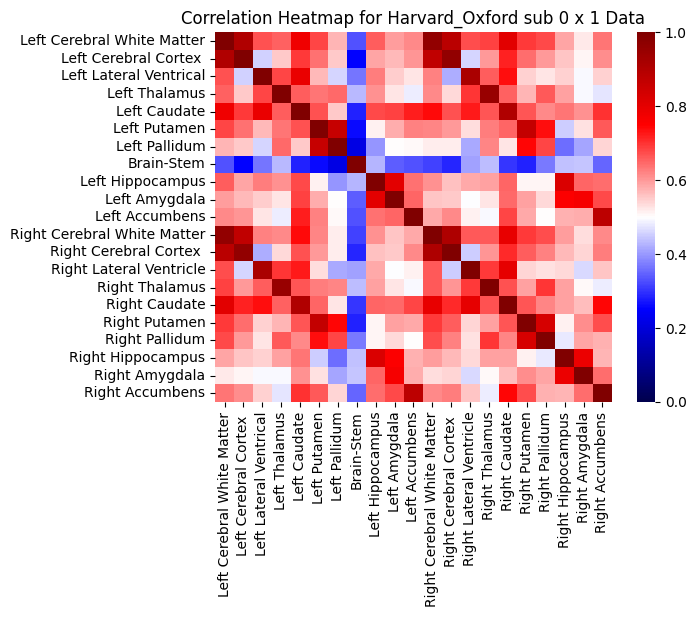

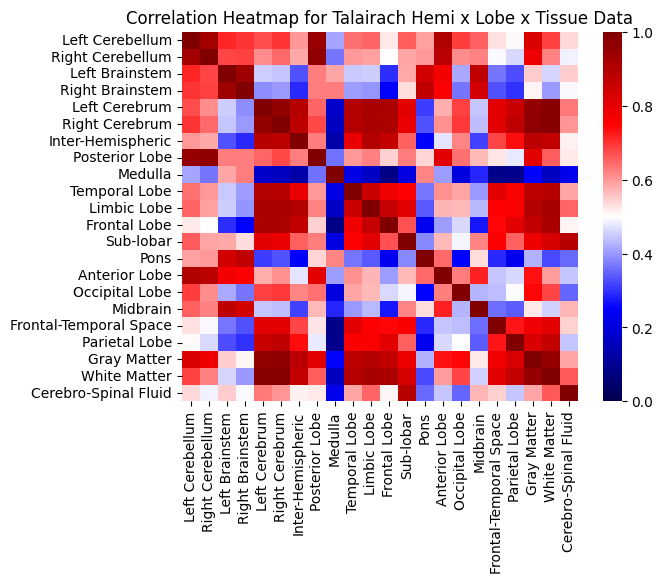

In [101]:
# correlation matrices
def corr_matrix(dataset):

    # Drop non-numeric or irrelevant columns
    columns_to_exclude = ['filename', 'emotion', 'subject', 'priming']
    df = brain_parcellations[dataset].drop(columns=columns_to_exclude, errors='ignore')
    
    # Plot correlation heatmap
    sns.heatmap(df.corr(), cmap='seismic', vmin=0, vmax=1)
    plt.title(f"Correlation Heatmap for {dataset} Data")
    plt.show()


corr_matrix('Harvard_Oxford sub 0 x 1')
corr_matrix('Talairach Hemi x Lobe x Tissue')

In [ ]:
def calc_vif(X):

    # create VIF dataframe for covariates
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [vif(X.values, i) for i in range(len(X.columns))]
    vif_data = vif_data.sort_values(by=['VIF'], ascending=False) 
    return vif_data
    

def del_multico(df, num, by='num'):
    """
    purpose: removes multicollinear features from df based on VIF.

    params:
        df: pd.DataFrame: feature variables
        num: int or float:
                If `by='num'`, number of features to remove.
                If `by='thres'`, maximum allowed VIF value.
        by: str: removal strategy: 'num' (fixed number) or 'thres' (VIF threshold).

    output: 
        tuple:
            vif_df: pd.DataFrame: selected features after removing high VIF features
            perc_multico: float: percentages of features that were removed for high VIF values
    """

    new_X = df.copy()  # Copy to avoid modifying the original dataframe

    while True:
        vif_df = calc_vif(new_X)  # Recalculate VIF
        
        # Check if all VIF values are below threshold
        if vif_df["VIF"].max() < num:
            break  # Stop if all VIFs are below threshold

        # Find feature with the highest VIF
        feature_to_remove = vif_df.sort_values("VIF", ascending=False).iloc[0]["feature"]

        # Drop feature
        new_X = new_X.drop(columns=[feature_to_remove])

    perc_multico = round(len(new_X.columns)/len(df.columns)*100, 3)
    return vif_df, perc_multico

In [ ]:
# calculate VIF
perc_multico = {}

# for each parcellation subdataset display the non-collinear features
for key in brain_parcellations.keys():
    if (key != 'Talairach Hemi') and (key != 'Talairach Lobe') and (key != 'Talairach Tissue'):
        df = brain_parcellations[key]
        print(key)
        vif_df, perc = del_multico(df, 5, 'thres')
        perc_multico[key] = perc
        display(vif_df)
        print('\n\n')

Harvard_Oxford cort 0 x 1


,feature,VIF
0,Superior Frontal Gyrus,4.992923
7,Subcallosal Cortex,4.885827
6,Juxtapositional Lobule Cortex (formerly Supple...,4.747391
5,Frontal Medial Cortex,4.570308
14,Parietal Operculum Cortex,4.372740
4,Angular Gyrus,4.267997
8,"Cingulate Gyrus, anterior division",3.792892
3,Superior Parietal Lobule,3.781743
13,Frontal Operculum Cortex,3.727519
1,"Middle Temporal Gyrus, anterior division",3.669130





Harvard_Oxford cortl 0 x 1


,feature,VIF
2,"Right Superior Temporal Gyrus, anterior division",4.897853
19,Right Frontal Operculum Cortex,4.487662
1,"Left Inferior Frontal Gyrus, pars triangularis",4.289173
10,Right Angular Gyrus,4.184431
22,Right Heschl's Gyrus (includes H1 and H2),4.180761
9,Left Angular Gyrus,4.147236
21,Left Planum Polare,4.027506
3,"Left Middle Temporal Gyrus, anterior division",3.973606
4,"Right Middle Temporal Gyrus, anterior division",3.931173
20,Right Parietal Operculum Cortex,3.811040





Harvard_Oxford sub 0 x 1


,feature,VIF
7,Right Caudate,4.541904
8,Right Pallidum,4.077408
5,Right Cerebral White Matter,3.874925
6,Right Thalamus,3.515778
3,Left Hippocampus,2.816686
1,Left Pallidum,2.708553
9,Right Amygdala,2.633833
4,Left Accumbens,2.233649
0,Left Lateral Ventrical,1.815576
2,Brain-Stem,1.469415





Juelich 0 x 1


,feature,VIF
10,GM Premotor cortex BA6,4.895424
12,GM Primary motor cortex BA4a,4.770313
6,GM Inferior parietal lobule Pga,4.174273
9,GM Medial geniculate body,4.124110
11,GM Primary auditory cortex TE1.2,4.096506
5,GM Inferior parietal lobule PGp,4.017079
13,GM Secondary somatosensory cortex / Parietal o...,3.819373
4,GM Inferior parietal lobule PF,3.726042
2,GM Hippocampus cornu ammonis,3.643976
15,GM Superior parietal lobule 5L,3.557683





AAL SPM12


,feature,VIF
19,Cerebelum_Crus1_R,4.801360
20,Cerebelum_Crus2_L,4.668320
10,Parietal_Inf_R,4.611849
1,Frontal_Inf_Oper_L,4.580656
13,Angular_R,4.540282
3,Frontal_Sup_Medial_R,4.490844
28,Vermis_9,4.476419
11,SupraMarginal_R,4.428955
5,Cingulum_Mid_L,4.365386
0,Frontal_Sup_Orb_R,4.265032





Talairach Gyrus


,feature,VIF
5,Tuber of Vermis,4.904341
14,Lentiform Nucleus,4.609449
19,Angular Gyrus,4.475005
10,Subcallosal Gyrus,4.389854
17,Supramarginal Gyrus,4.294330
2,Uvula of Vermis,4.162302
18,Cingulate Gyrus,4.068094
4,Tuber,4.025020
1,Uncus,3.616178
20,Superior Parietal Lobule,3.614388





Talairach Ba


,feature,VIF
17,Brodmann area 40,4.648970
7,Putamen,4.641370
10,Caudate Head,4.621763
0,Brodmann area 20,4.566094
20,Brodmann area 8,4.167440
12,Ventral Posterior Lateral Nucleus,4.072674
15,Brodmann area 23,4.069999
9,Brodmann area 27,3.910834
11,Anterior Commissure,3.625010
8,Brodmann area 10,3.357386





Schaefer 100 x 7 x 1


,feature,VIF
11,b'7Networks_LH_Default_PFC_3',4.807069
3,b'7Networks_LH_SalVentAttn_ParOper_1',4.759073
5,b'7Networks_LH_SalVentAttn_PFCl_1',4.476730
12,b'7Networks_LH_Default_PFC_4',4.398541
22,b'7Networks_RH_Default_Temp_2',4.333849
7,b'7Networks_LH_Limbic_TempPole_2',4.308378
24,b'7Networks_RH_Default_PFCdPFCm_3',4.271059
13,b'7Networks_LH_Default_PFC_7',4.203103
20,b'7Networks_RH_Cont_Par_1',4.156017
14,b'7Networks_RH_SomMot_2',4.123379





Talairach Hemi x Lobe x Tissue


,feature,VIF
1,Temporal Lobe,4.972503
2,Frontal Lobe,4.804711
6,Parietal Lobe,4.448257
5,Frontal-Temporal Space,4.353144
4,Occipital Lobe,2.471098
3,Pons,1.991492
7,Cerebro-Spinal Fluid,1.688543
0,Medulla,1.675514


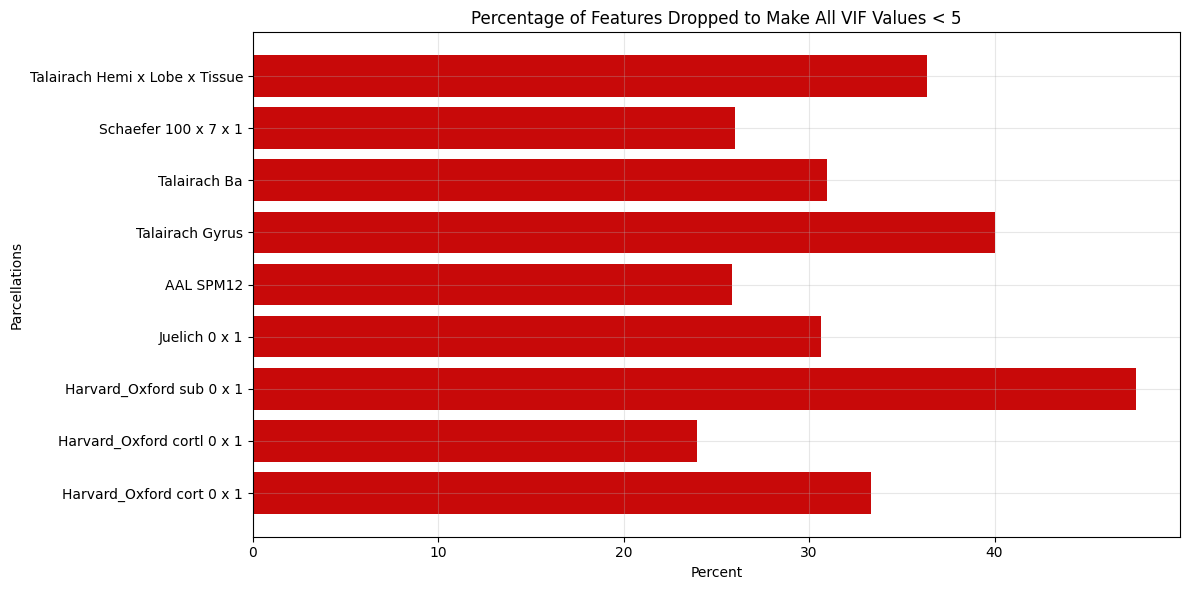

In [114]:
# visualize percentages of multicollineratiry in brain parcellation features
keys = list(perc_multico.keys())
vals = list(perc_multico.values())

plt.figure(figsize=(12, 6))
plt.barh(keys, vals, color='#c80909')

plt.title('Percentage of Features Dropped to Make All VIF Values < 5')
plt.xlabel('Percent')
plt.ylabel('Parcellations')


plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

## **Brain Parcellation Visuals**

In [ ]:
def plot_parcellation_map(atlas, maps, cut_coords = (3,-30,13)):
    '''
    purpose: plot visualization to show the areas of the brain divivded in parcellation atlas
        
    params:
        atlas_name : str: Name of brain parcellation technique  
        atlas_types : dict: Dictionary of parcellation atlases and their maps and labels   
        cut_coords : tuple Coordinates for brain visualization
    
    output: none, displays visualization of brain data
    '''
    
    atlas_map = maps[atlas]
    
    if type(atlas_map) == tuple:
        atlas_map = atlas_map[0]
    
    if type(atlas_map) == str or list:
        dim = get_data(atlas_map).ndim
        
    else:
        dim = atlas_map.ndim
    
    if dim == 4:
        plotting.plot_prob_atlas(atlas_map, cut_coords = cut_coords, title = atlas, black_bg=True)
        plt.show()
        
    else:
        plotting.plot_roi(atlas_map, cut_coords=cut_coords, title = atlas, black_bg = True)
        plt.show()

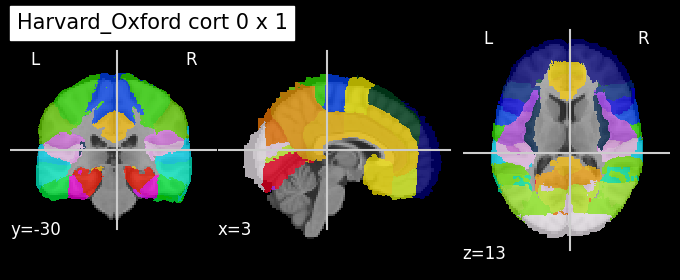

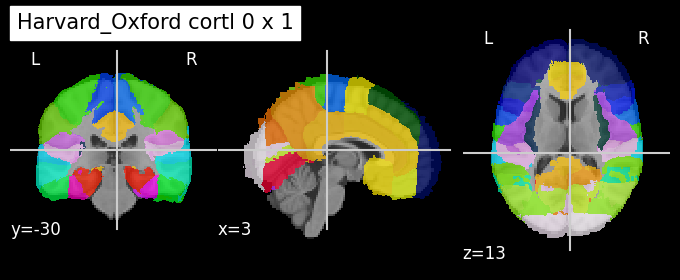

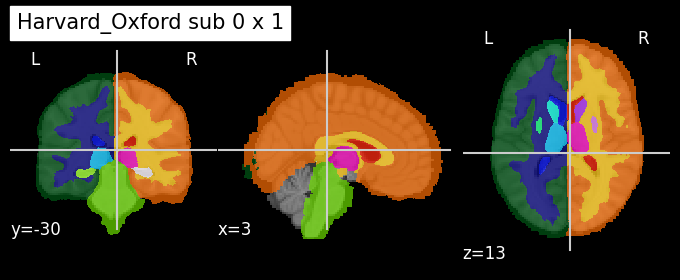

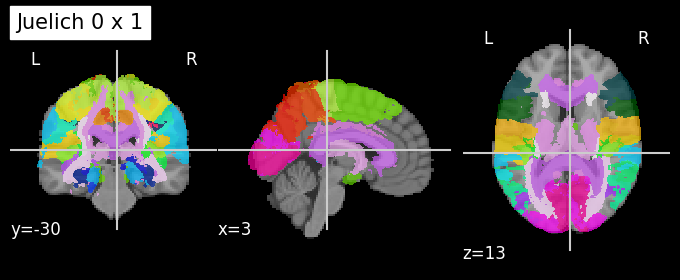

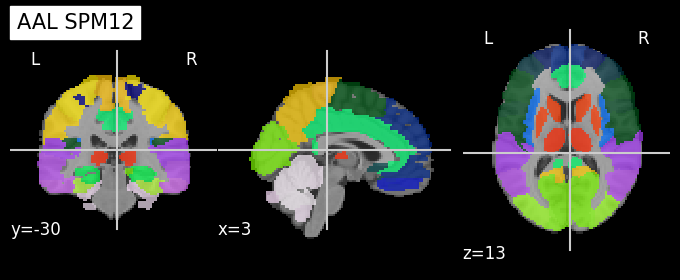

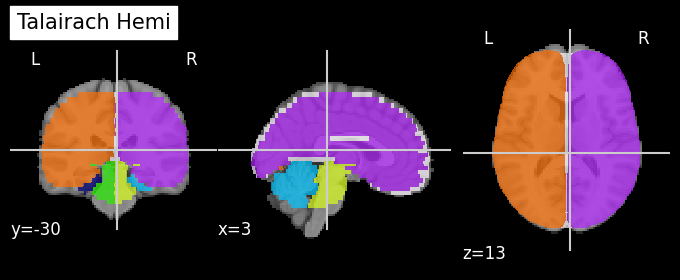

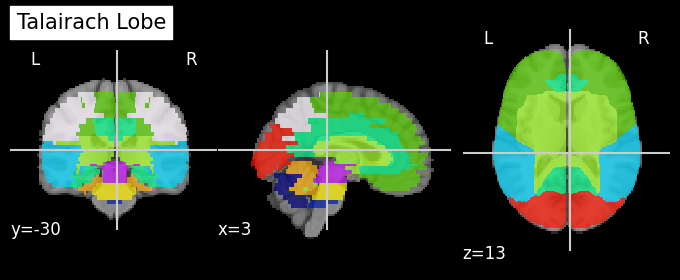

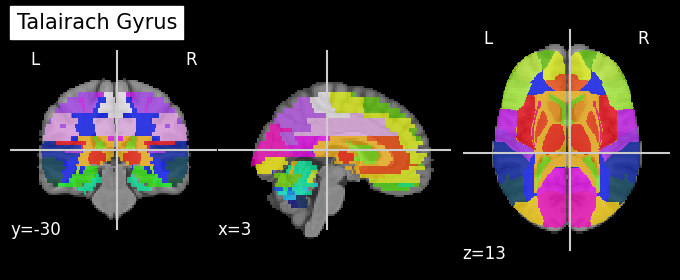

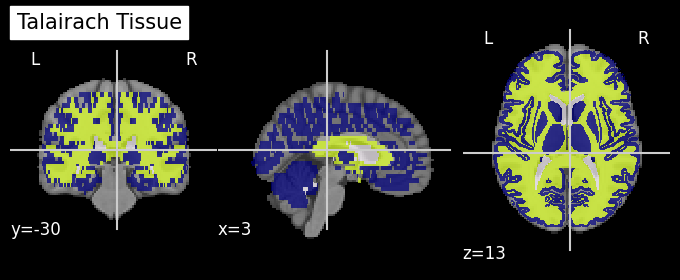

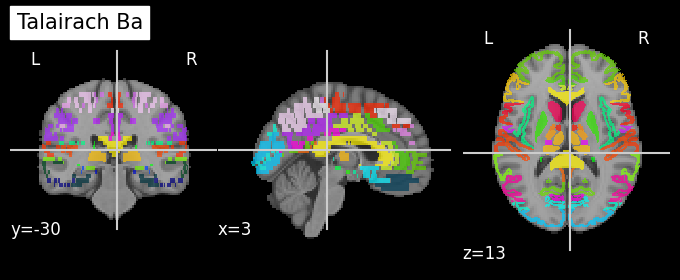

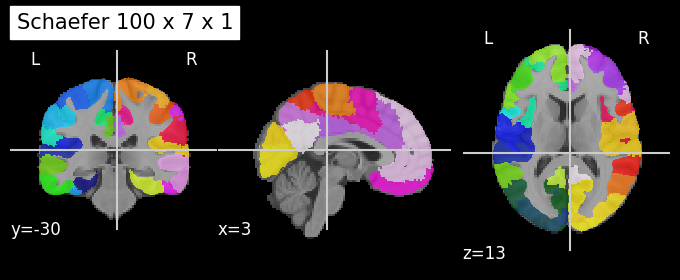

In [ ]:
# for each brain parcellation, display the visual map
for k in maps.keys():
    plot_parcellation_map(k, maps)

## **Heterogeneity of Y Across X For First Components**

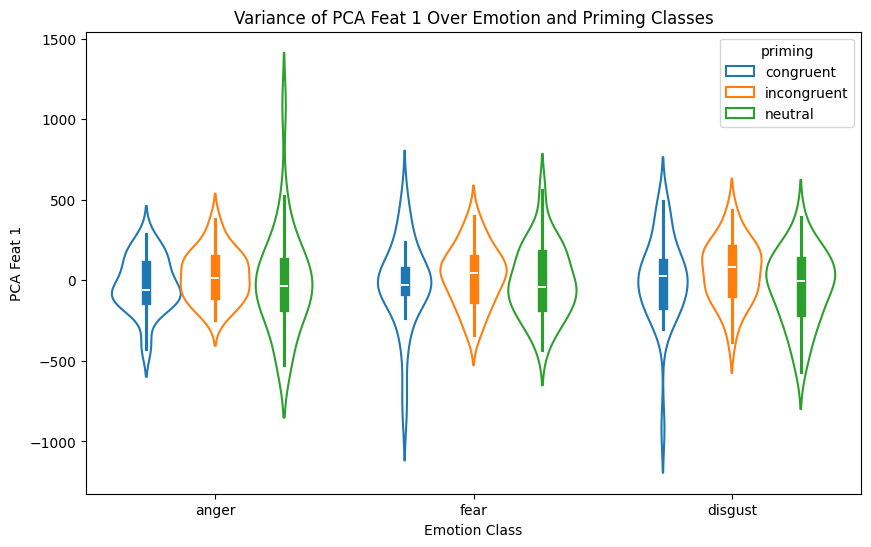

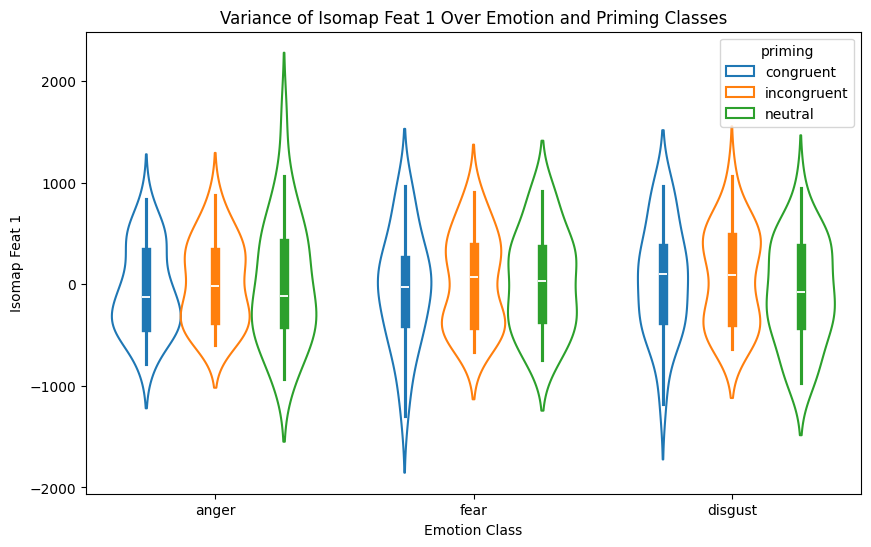

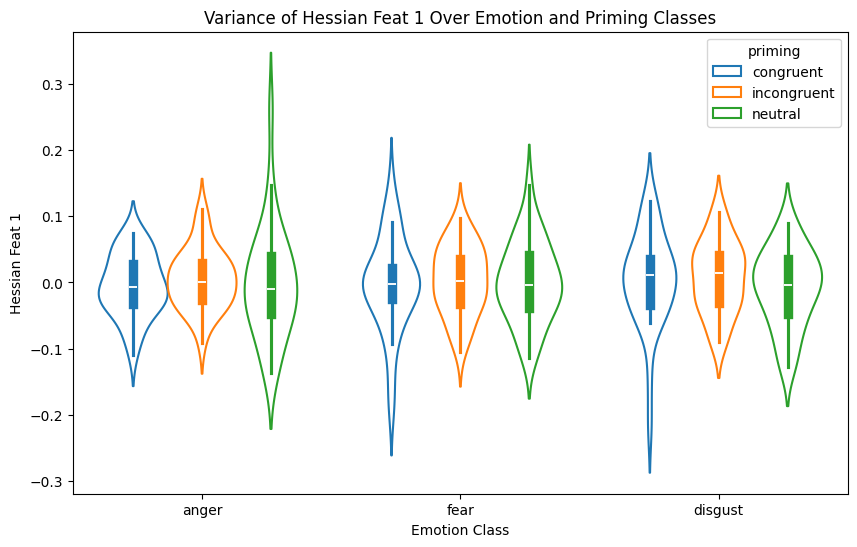

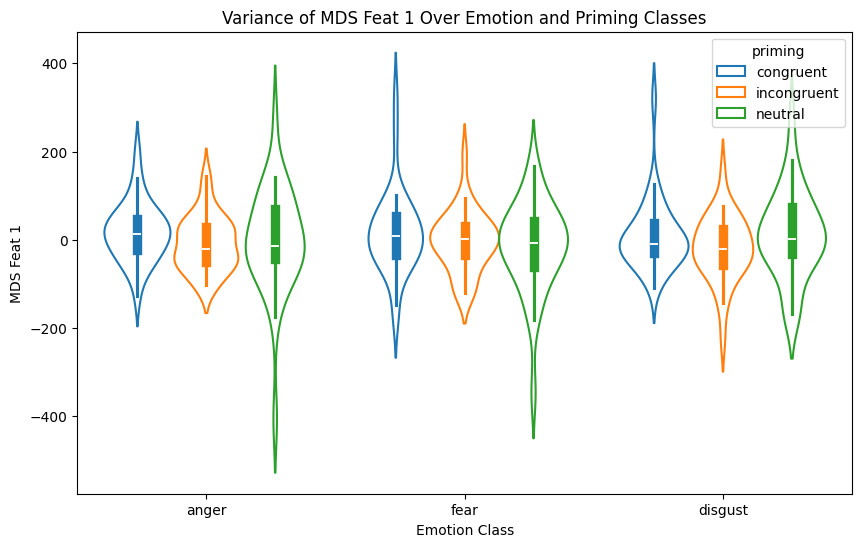

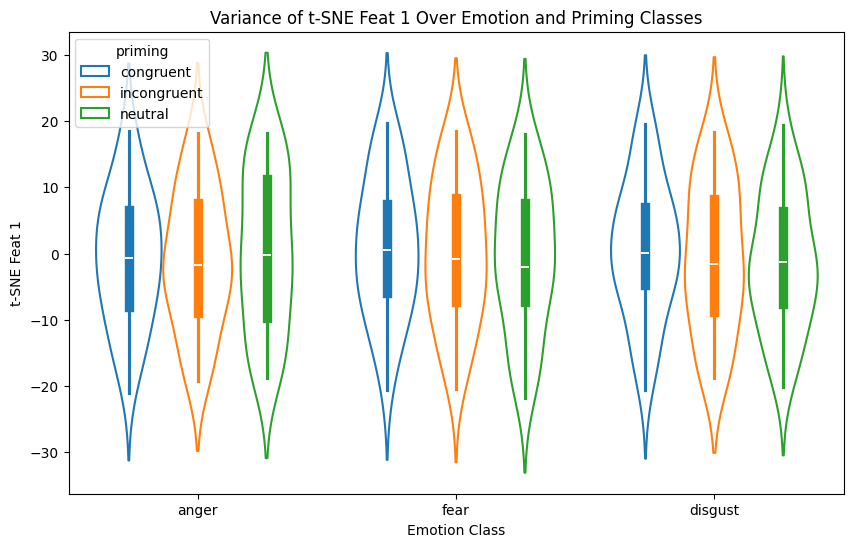

In [119]:
for k in dimension_reductions.keys():
    
    # create a new figure and axes for each plot
    plt.figure(figsize=(10, 6))
    
    # create the violin plot
    sns.violinplot(data=dimension_reductions[k], x="emotion", y="Feat 1", hue="priming", fill=False)

    # add the title and labels
    plt.title(f'Variance of {k} Feat 1 Over Emotion and Priming Classes')
    plt.xlabel('Emotion Class')
    plt.ylabel(f'{k} Feat 1')

    # Display the plot
    plt.show()


Is there greater variance when the brain is confused vs when the brain is focused?
Suprisingly, no. It's the opposite. the variance seems to be the most consistent when the brain is confused. maybe inactivity is a result of confusion.. 

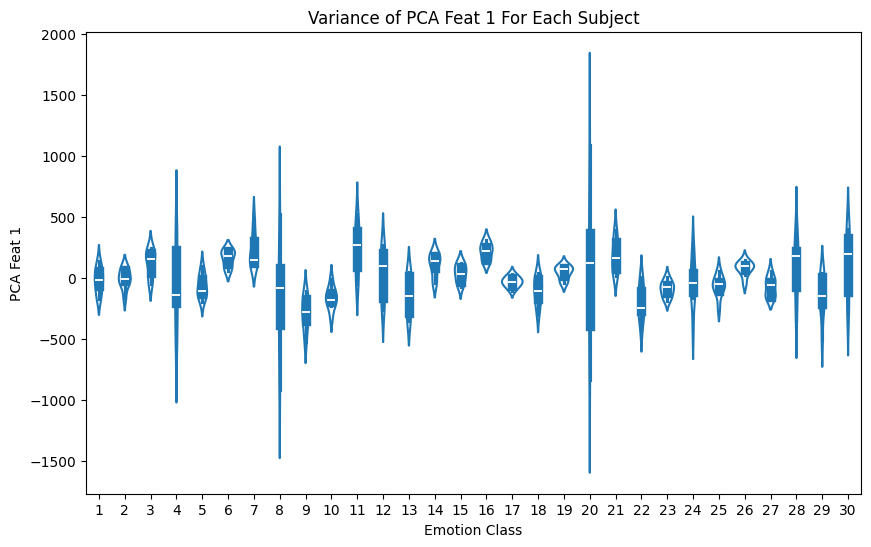

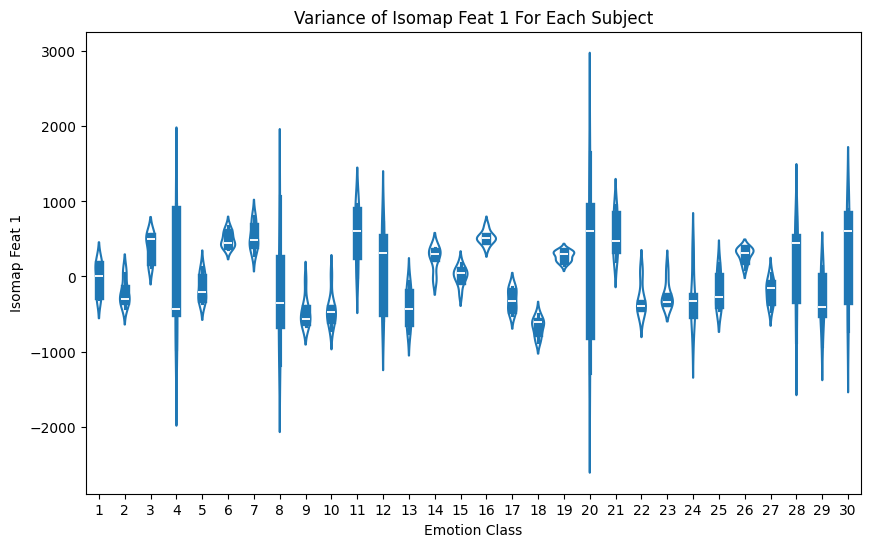

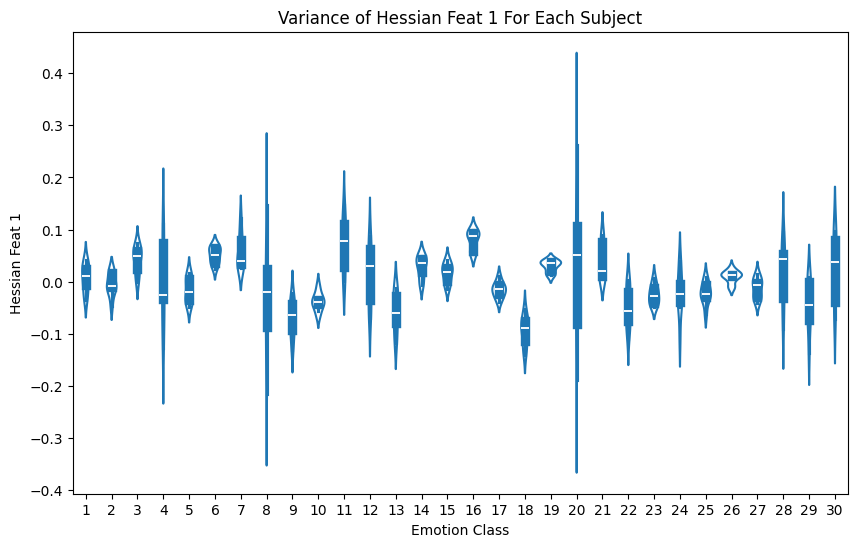

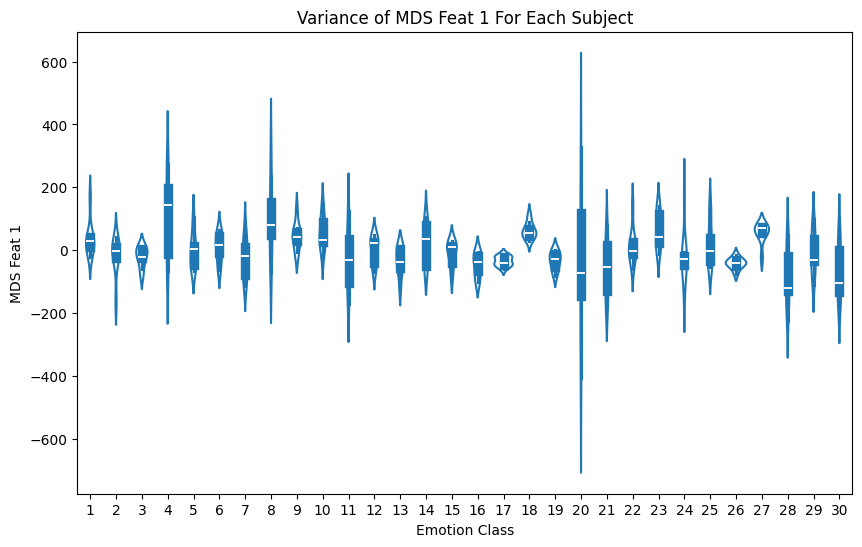

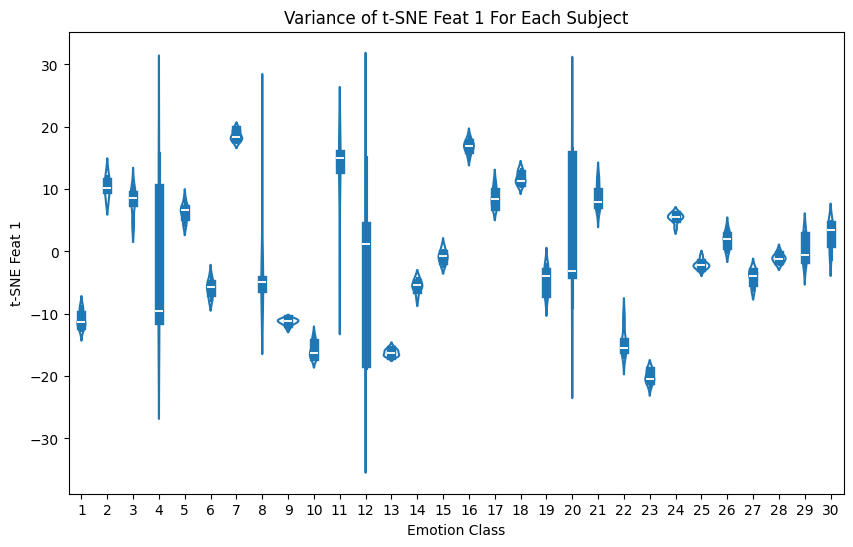

In [122]:
for k in dimension_reductions.keys():
    
    # create a new figure and axes for each plot
    plt.figure(figsize=(10, 6))
    
    # create the violin plot
    sns.violinplot(data=dimension_reductions[k], x="subject", y="Feat 1", fill=False)

    # add the title and labels
    plt.title(f'Variance of {k} Feat 1 For Each Subject')
    plt.xlabel('Emotion Class')
    plt.ylabel(f'{k} Feat 1')

    # Display the plot
    plt.show()


## **Dimension Reduction Visuals**

look at linearly separability in 2D space

In [124]:
# 2D dimension reduction
X_pca_2D = PCA(n_components=2).fit_transform(X) 
X_tsne_2D = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X) 
X_isomap_2D = Isomap(n_components=2, n_neighbors=10).fit_transform(X) 
X_hessian_2D = LocallyLinearEmbedding(n_components=2, method='hessian', n_neighbors=262).fit_transform(X) 
X_mds_2D = MDS(n_components=2, dissimilarity='euclidean', normalized_stress='auto').fit_transform(X)

In [128]:
# create dictionary for datasets of each dimension reduction method
dimension_redux_2D = {'PCA': X_pca_2D, 'Isomap': X_isomap_2D, 'Hessian': X_hessian_2D, 'MDS': X_mds_2D, 't-SNE': X_tsne_2D}

# save data as csv files to decrease loading time when kernel dies
for key in dimension_redux_2D.keys():
    data = dimension_redux_2D[key]
    names = [f'Feat {i+1}' for i in range(len(data.T))]
    df = pd.DataFrame(data, columns=names)
    df['filename'] = files
    df['subject'] = subject_no
    df['emotion'] = emotion_class
    df['priming'] = priming_class
    df.to_csv(f'./data/two-dimensions/{key}.csv', index=False)

In [ ]:
dimension_redux_2D = {key: pd.read_csv(f'./data/two-dimensions/{key}.csv') for key in dim_redux_methods.keys()}

/var/folders/gd/vj6nrxx1037dp6b1bqg_hg3c0000gn/T/ipykernel_77693/3639857881.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('viridis', num_classes)


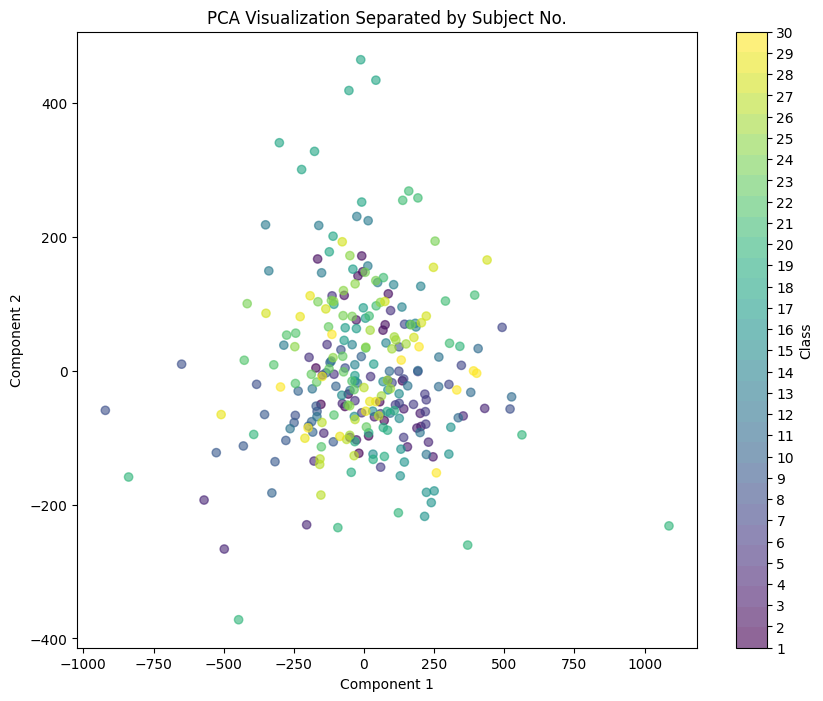

/var/folders/gd/vj6nrxx1037dp6b1bqg_hg3c0000gn/T/ipykernel_77693/3639857881.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('viridis', num_classes)


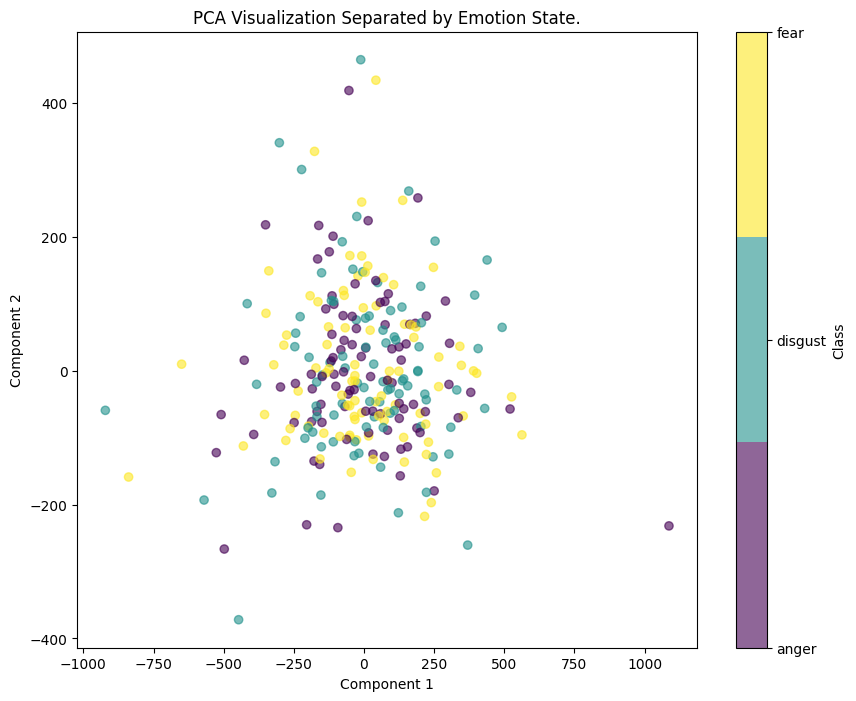

/var/folders/gd/vj6nrxx1037dp6b1bqg_hg3c0000gn/T/ipykernel_77693/3639857881.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('viridis', num_classes)


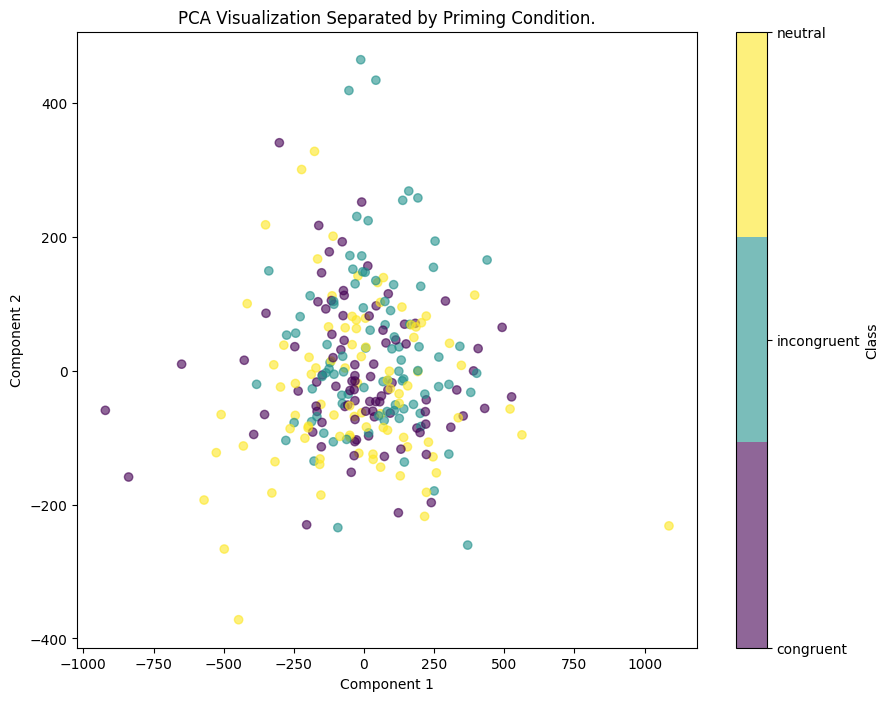

/var/folders/gd/vj6nrxx1037dp6b1bqg_hg3c0000gn/T/ipykernel_77693/3639857881.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('viridis', num_classes)


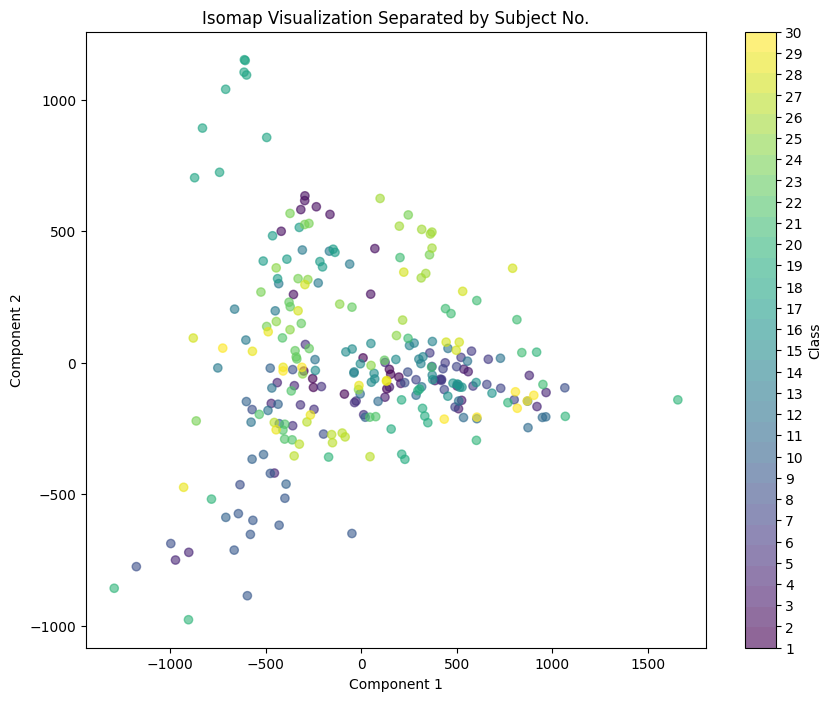

/var/folders/gd/vj6nrxx1037dp6b1bqg_hg3c0000gn/T/ipykernel_77693/3639857881.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('viridis', num_classes)


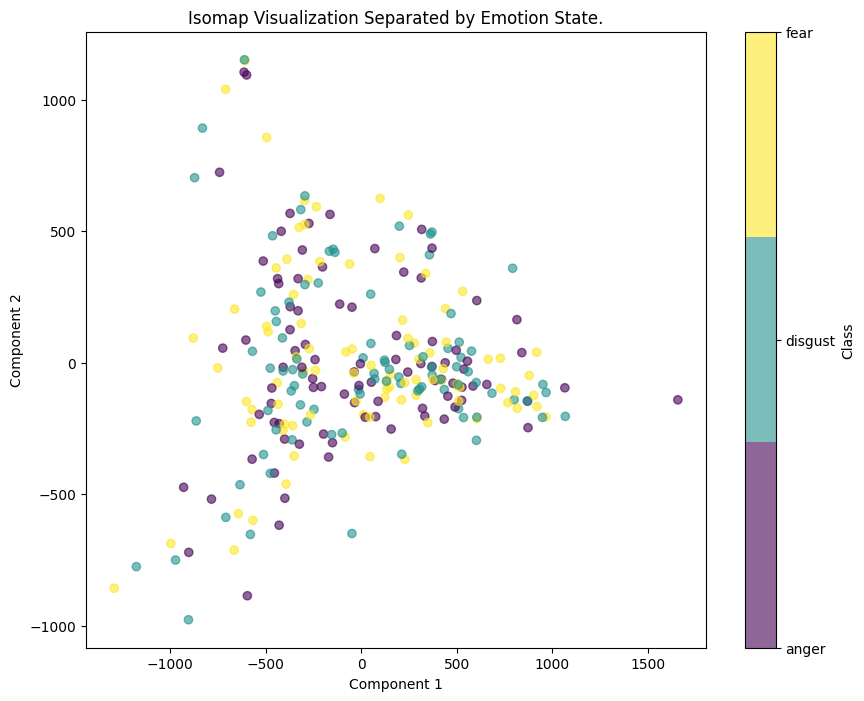

/var/folders/gd/vj6nrxx1037dp6b1bqg_hg3c0000gn/T/ipykernel_77693/3639857881.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('viridis', num_classes)


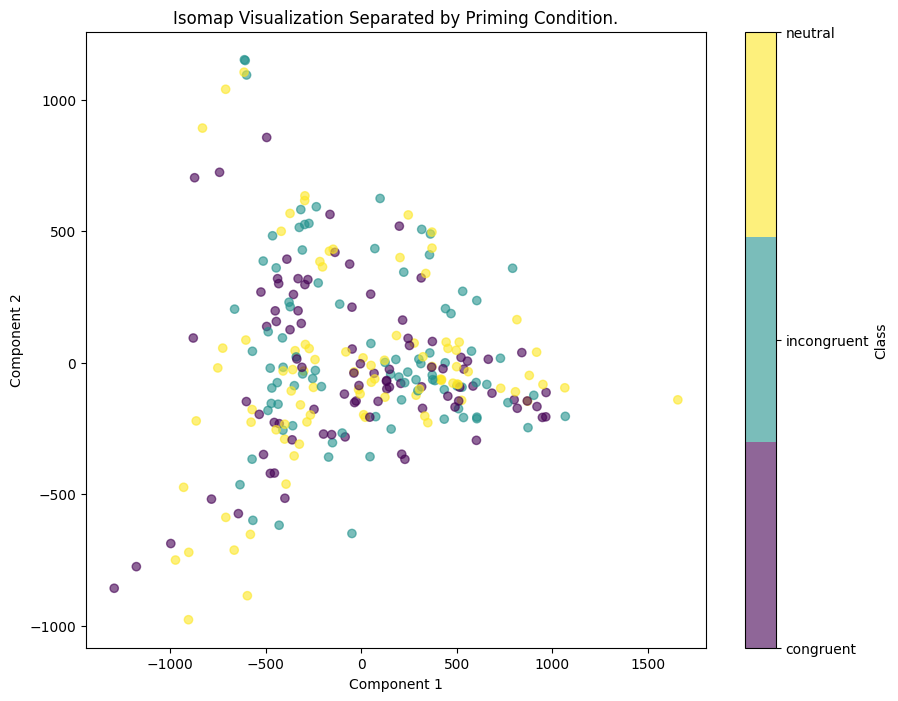

/var/folders/gd/vj6nrxx1037dp6b1bqg_hg3c0000gn/T/ipykernel_77693/3639857881.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('viridis', num_classes)


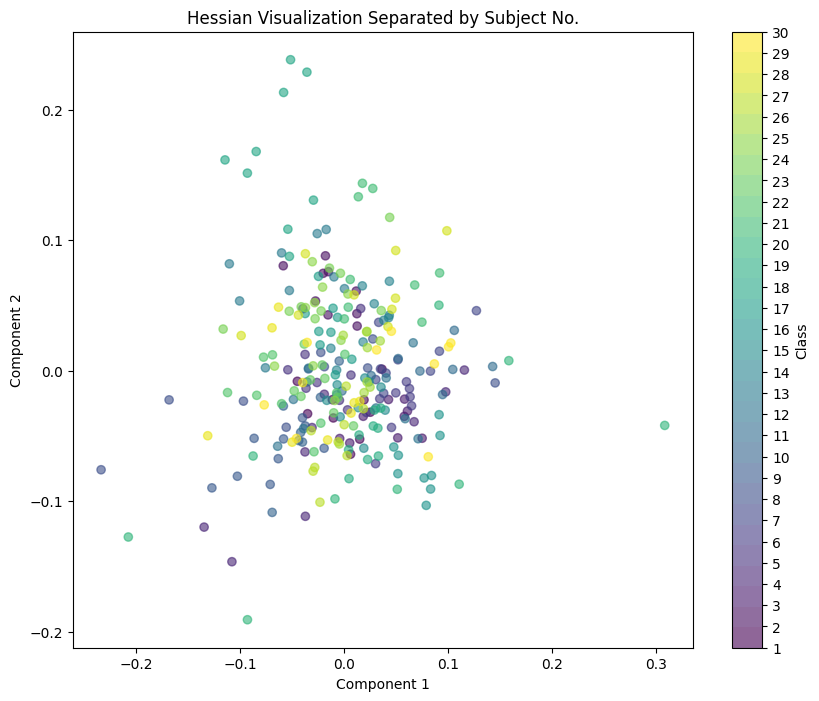

/var/folders/gd/vj6nrxx1037dp6b1bqg_hg3c0000gn/T/ipykernel_77693/3639857881.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('viridis', num_classes)


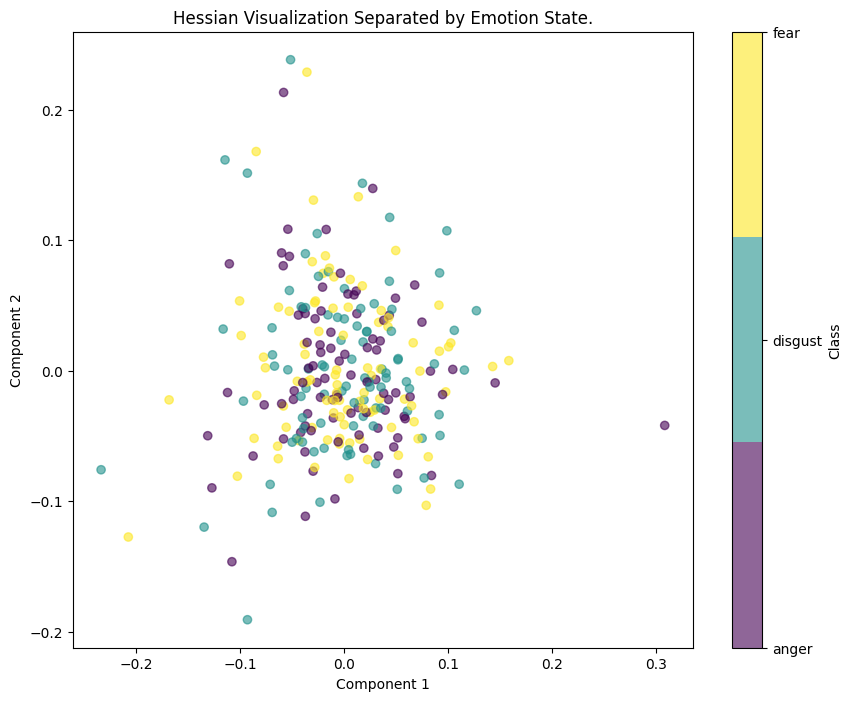

/var/folders/gd/vj6nrxx1037dp6b1bqg_hg3c0000gn/T/ipykernel_77693/3639857881.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('viridis', num_classes)


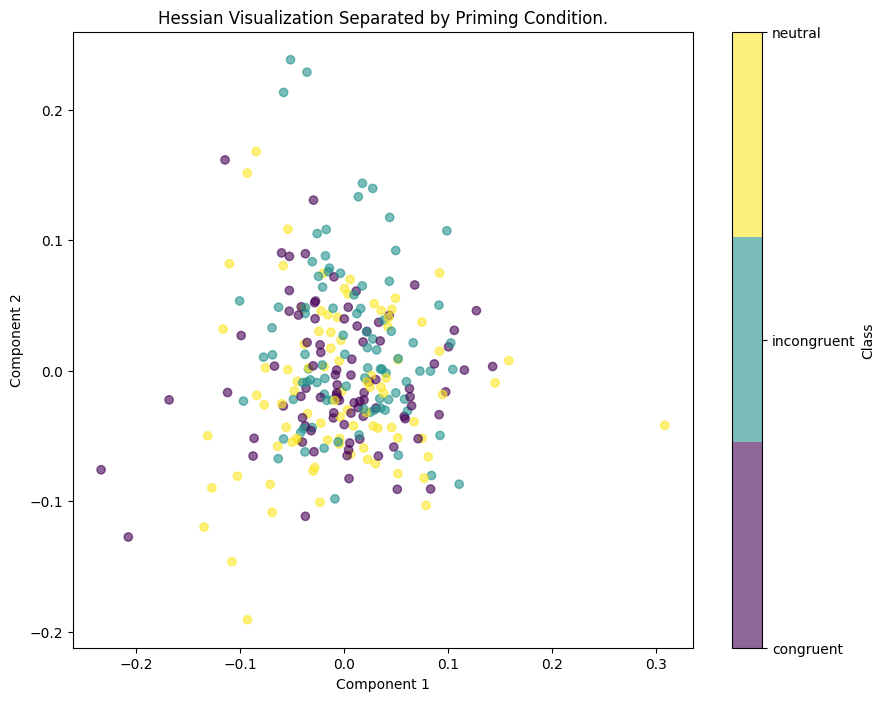

/var/folders/gd/vj6nrxx1037dp6b1bqg_hg3c0000gn/T/ipykernel_77693/3639857881.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('viridis', num_classes)


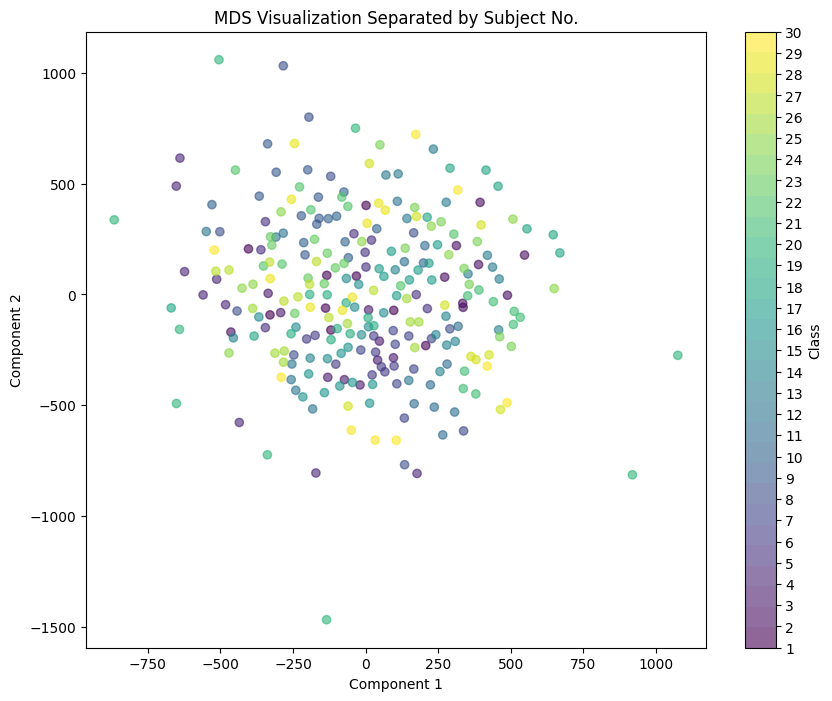

/var/folders/gd/vj6nrxx1037dp6b1bqg_hg3c0000gn/T/ipykernel_77693/3639857881.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('viridis', num_classes)


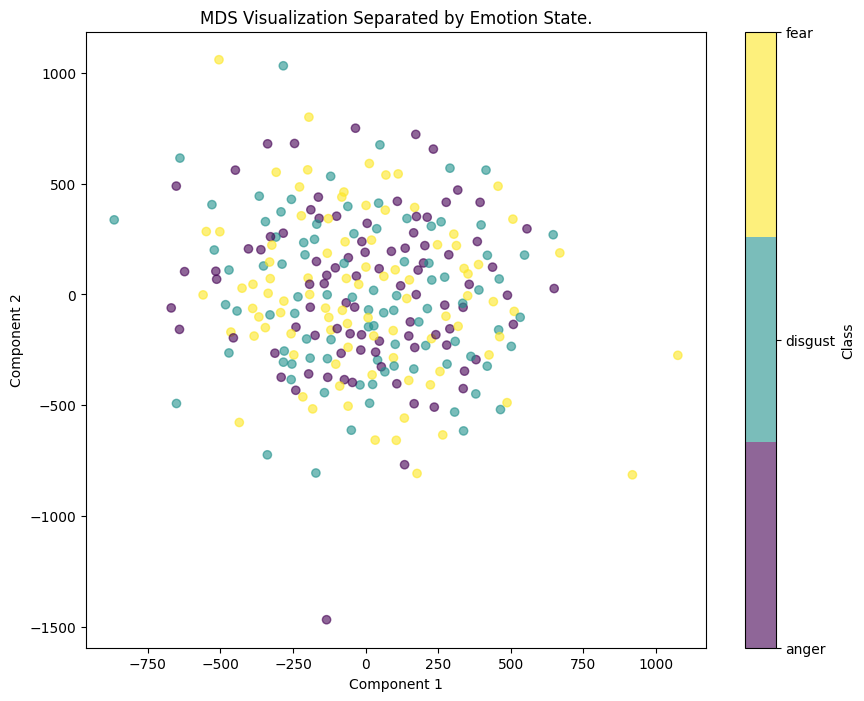

/var/folders/gd/vj6nrxx1037dp6b1bqg_hg3c0000gn/T/ipykernel_77693/3639857881.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('viridis', num_classes)


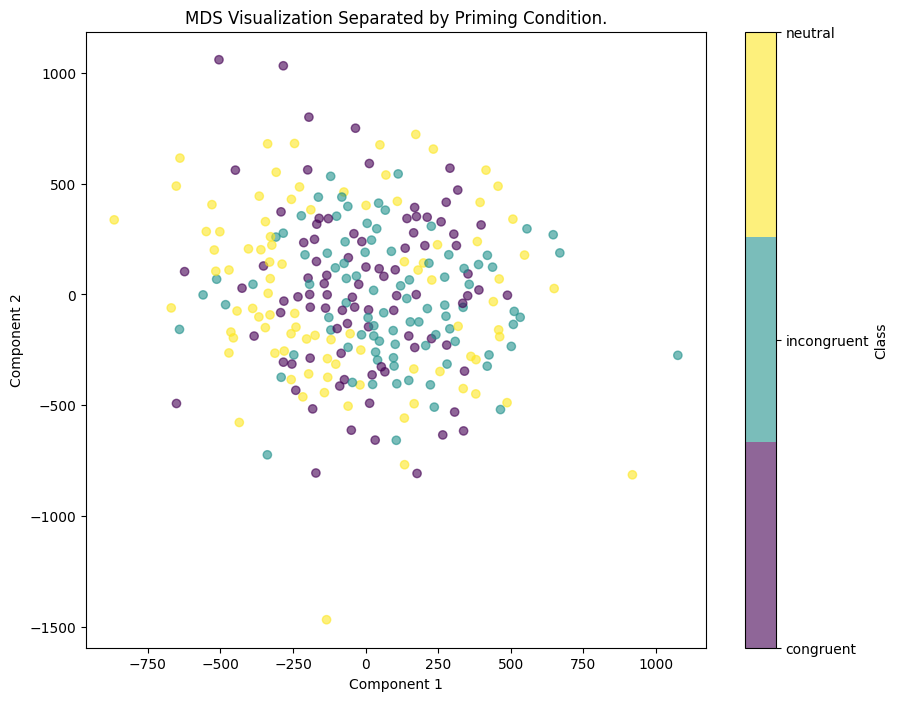

/var/folders/gd/vj6nrxx1037dp6b1bqg_hg3c0000gn/T/ipykernel_77693/3639857881.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('viridis', num_classes)


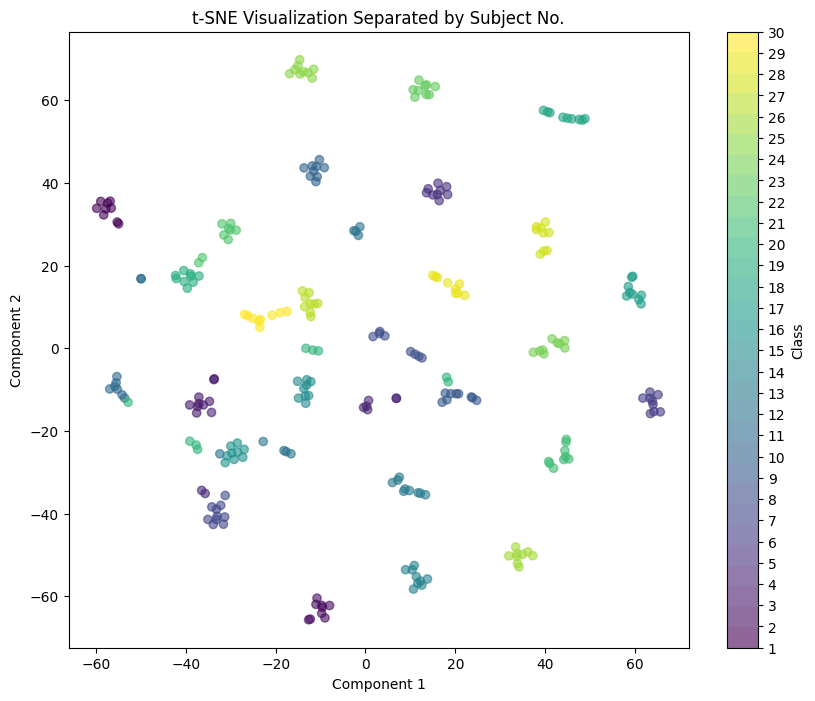

/var/folders/gd/vj6nrxx1037dp6b1bqg_hg3c0000gn/T/ipykernel_77693/3639857881.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('viridis', num_classes)


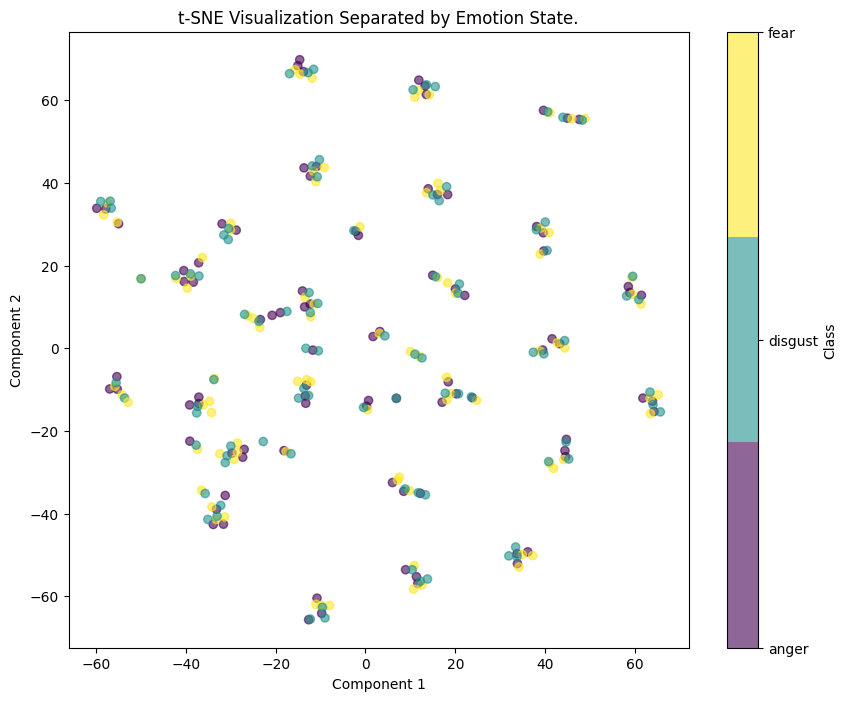

/var/folders/gd/vj6nrxx1037dp6b1bqg_hg3c0000gn/T/ipykernel_77693/3639857881.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('viridis', num_classes)


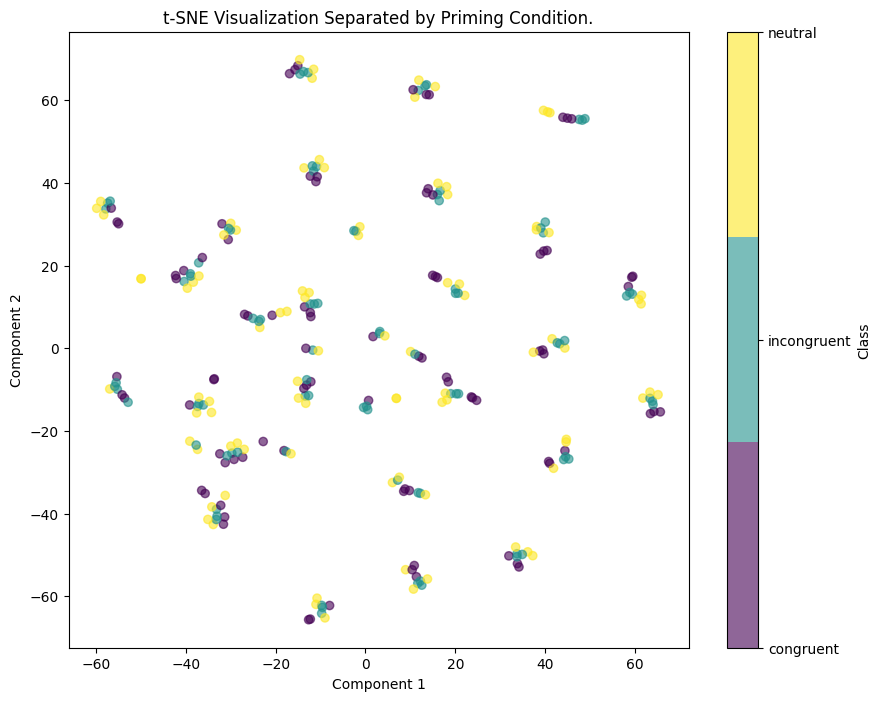

In [143]:
# encode your categorical labels into numerical values
le_emotion = LabelEncoder()
le_subject = LabelEncoder()
le_priming = LabelEncoder()

# Fit and transform the categorical data
emotion_encoded = le_emotion.fit_transform(emotion_class) 
subject_encoded = le_subject.fit_transform(subject_no)
priming_encoded = le_priming.fit_transform(priming_class) 


def plot_embeddings(X_emb, y_encoded, title, filename=None, label_encoder=None):
    '''
    purpose: plot 2D embeddings with numerical labels
    params:
        X_emb: 2D array of embeddings
        y_encoded: 1D array of numerical labels (e.g., output of LabelEncoder)
        title: str, plot title
        filename: str, optional, name to save the plot
        label_encoder: sklearn.preprocessing.LabelEncoder, optional, to show original labels in colorbar
    output: none, shows plot and saves to directory
    '''

    plt.figure(figsize=(10, 8))

    # Determine the number of unique classes for the current plot
    num_classes = len(np.unique(y_encoded))
    
    # You can choose a different base colormap if 'viridis' isn't to your taste
    base_cmap = plt.cm.get_cmap('spectral', num_classes)
    custom_cmap = ListedColormap([base_cmap(i) for i in range(num_classes)])

    scatter = plt.scatter(X_emb[:, 0], X_emb[:, 1], c=y_encoded, cmap=custom_cmap, alpha=0.6)

    if label_encoder:
        cbar = plt.colorbar(scatter, ticks=np.unique(y_encoded), label='Class')
        # Ensure that ticks match the actual unique encoded values
        cbar.ax.set_yticklabels(label_encoder.inverse_transform(np.unique(y_encoded)))
    else:
        plt.colorbar(scatter, label='Class')

    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    if filename:
        plt.savefig('./visualizations/two-dimensions/{filename}')
    plt.show()

# plot results
for key in dimension_redux_2D.keys():
    
    plot_embeddings(dimension_redux_2D[key], subject_encoded,
                    f"{key} Visualization Separated by Subject No.",
                    f"{key}_subject.png", label_encoder=le_subject)

    plot_embeddings(dimension_redux_2D[key], emotion_encoded,
                    f"{key} Visualization Separated by Emotion State.",
                    f"{key}_emotion.png", label_encoder=le_emotion)

    plot_embeddings(dimension_redux_2D[key], priming_encoded,
                    f"{key} Visualization Separated by Priming Condition.",
                    f"{key}_priming.png", label_encoder=le_priming)

Look to see separability to help assess if there is easily differntiabiltiy between different types of categories:
No, it is clear at least for tSNE that the underlying mechanism driving the low dimensional mapping is the subject. Regardless of the classes, emotion or priming, there needs to be a way to consider hierarchical classification because that is dominating the variance of the features

# **Model Development**

* Configurations:
    * Model: Logistic Regression (Hierarchical, Non-Hierarchical)
    * Lower-Dimensional Data (13 variations)
        * t-SNE
        * Isomap
        * Hessian
        * MDS
        * PCA
        * AAL SPM12
        * Harvard Oxford Cort 0 x 1
        * Harvard Oxford Cortl 0 x 1
        * Harvard Oxford Sub 0 x 1
        * Juelich 0 x 1
        * Schaefer 100 x 7 x 1
        * Talairach Gyrus
        * Talairach Hemisphere x Lobe x Tissue
* K-Fold Cross Validation
    * Train and test splits have to be done by patient because of the hierarhcial and IID violation
    * Data Leakage: If you randomly split your data (e.g., using train_test_split or standard KFold), data points from the same patient might end up in both the training and testing sets. This makes your model seem better than it is because it has "seen" aspects of the test patients during training.

In [ ]:
class Hierarchical_K_Fold_CV:

    def __init__(self, data, hier_class, target_class):
        '''
        params:
            data: pd.DataFrame: input and mutlticlass target variables
            hier_class: str: column name for categorical variable that identifies samples that are related
            target_class: str: column name for categorical variable classifier will predict
        '''
        self.data = data
        self.hier_class = hier_class
        self.target_class = target_class

    def _seperate_input_target(self):

        # target vars = hierarchical + target class

        # input vars = columns where data type = int or float
        

In [ ]:
def k_fold_cross_validation(X, y, model, k=5):
    n_samples = X.shape[0]
    fold_size = n_samples // k

    # initialize metrics
    test_accuracies = []
    test_recall_scores = []
    test_precision_scores = []
    test_f1_scores = []
    test_roc_scores = []

    train_accuracies = []
    train_recall_scores = []
    train_precision_scores = []
    train_f1_scores = []
    train_roc_scores = []



    for i in range(k):

        # Split data
        test_indices = range(i*fold_size, (i+1)*fold_size)
        train_indices = list(set(range(n_samples)) - set(test_indices))

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Train and evaluate
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        test_accuracy, test_recall, test_precision, test_f1, test_roc_auc = evaluate_model(y_test, y_pred_test)
        train_accuracy, train_recall, train_precision, train_f1, train_roc_auc = evaluate_model(y_train, y_pred_train)



        # append results
        test_accuracies.append(test_accuracy)
        test_recall_scores.append(test_recall)
        test_precision_scores.append(test_precision)
        test_f1_scores.append(test_f1)
        test_roc_scores.append(test_roc_auc)
        train_accuracies.append(train_accuracy)
        train_recall_scores.append(train_recall)
        train_precision_scores.append(train_precision)
        train_f1_scores.append(train_f1)
        train_roc_scores.append(train_roc_auc)


    # return average metrics
    test_acc_avg = np.mean(test_accuracies)
    test_recall_avg = np.mean(test_recall_scores)
    test_precision_avg = np.mean(test_precision_scores)
    test_f1_avg = np.mean(test_f1_scores)
    test_roc_auc_avg = np.mean(test_roc_scores)

    train_acc_avg = np.mean(train_accuracies)
    train_recall_avg = np.mean(train_recall_scores)
    train_precision_avg = np.mean(train_precision_scores)
    train_f1_avg = np.mean(train_f1_scores)
    train_roc_auc_avg = np.mean(train_roc_scores)

    results = {
        'test_accuracy': test_acc_avg,
        'test_recall': test_recall_avg,
        'test_precision': test_precision_avg,
        'test_f1': test_f1_avg,
        'test_roc_auc': test_roc_auc_avg,
        'train_accuracy': train_acc_avg,
        'train_recall': train_recall_avg,
        'train_precision': train_precision_avg,
        'train_f1': train_f1_avg,
        'train_roc_auc': train_roc_auc_avg
    }

    return results

In [1]:
from sklearn.model_selection import GroupKFold
n_splits = min(5, len(np.unique(groups))) # Use 5 folds, or fewer if not enough unique subjects
group_kfold = GroupKFold(n_splits=n_splits)

NameError: name 'np' is not defined

In [ ]:
for fold_idx, (train_index, test_index) in enumerate(group_kfold.split(X, Y, groups)):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    # ... (train and predict HiClass classifier)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from hiclass import LocalClassifierPerNode

rf_classifier = RandomForestClassifier(random_state=42)
hiclass_classifier = LocalClassifierPerNode(local_classifier=rf_classifier)

hiclass_classifier.fit(X_train, Y_train)
fold_predictions = hiclass_classifier.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
fold_accuracy = accuracy_score(Y_test, fold_predictions)
# ... (store and average accuracies)

In [ ]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=5) # Example: 5 folds
for train_idx, test_idx in group_kfold.split(X, Y, groups=patient_id):
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    Y_train_fold, Y_test_fold = Y[train_idx], Y[test_idx]
    # Important: patient_id[train_idx] and patient_id[test_idx] will have no overlap!

In [ ]:
from hiclass import LocalClassifierPerNode
    from sklearn.ensemble import RandomForestClassifier

    base_classifier = RandomForestClassifier(random_state=42)
    hiclass_model = LocalClassifierPerNode(local_classifier=base_classifier)

    hiclass_model.fit(X_train_fold, Y_train_fold)
    predictions_fold = hiclass_model.predict(X_test_fold)

    # Evaluate performance (e.g., using sklearn.metrics.accuracy_score)
    # Note: accuracy_score can directly compare lists of lists for hiclass outputs
    fold_accuracy = accuracy_score(Y_test_fold, predictions_fold)
    # Store fold_accuracy, etc.

In [ ]:
from hiclass import LocalClassifierPerNode
from sklearn.ensemble import RandomForestClassifier

# Define data
X_train = [[1], [2], [3], [4]]b
X_test = [[4], [3], [2], [1]]
Y_train = [
    ['Animal', 'Mammal', 'Sheep'],
    ['Animal', 'Mammal', 'Cow'],
    ['Animal', 'Reptile', 'Snake'],
    ['Animal', 'Reptile', 'Lizard'],
]

# Use random forest classifiers for every node
rf = RandomForestClassifier()
classifier = LocalClassifierPerNode(local_classifier=rf)

# Train local classifier per node
classifier.fit(X_train, Y_train)

# Predict
predictions = classifier.predict(X_test)

In [ ]:
from hiclass import LocalClassifierPerParentNode
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Define data
X_train = [
    'Struggling to repay loan',
    'Unable to get annual report',
]
X_test = [
    'Unable to get annual report',
    'Struggling to repay loan',
]
Y_train = [
    ['Loan', 'Student loan'],
    ['Credit reporting', 'Reports']
]

In [ ]:
# Use logistic regression classifiers for every parent node
lr = LogisticRegression()
pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lcppn', LocalClassifierPerParentNode(local_classifier=lr)),
])

In [ ]:
# Train local classifier per parent node
pipeline.fit(X_train, Y_train)

# Predict
predictions = pipeline.predict(X_test)

In [ ]:
https://github.com/scikit-learn-contrib/hiclass

* Configurations:
    * Model: Logistic Regression (Hierarchical, Non-Hierarchical)
    * Lower-Dimensional Data (14 variations)
        * t-SNE
        * Isomap
        * Hessian
        * MDS
        * PCA
        * AAL SPM12
        * Harvard Oxford Cort 0 x 1
        * Harvard Oxford Cortl 0 x 1
        * Harvard Oxford Sub 0 x 1
        * Juelich 0 x 1
        * Schaefer 100 x 7 x 1
        * Talairach Gyrus
        * Talairach Ba
        * Talairach Hemisphere x Lobe x Tissue
* K-Fold Cross Validation
    * 
    * Data Leakage: If you randomly split your data (e.g., using train_test_split or standard KFold), data points from the same patient might end up in both the training and testing sets. This makes your model seem better than it is because it has "seen" aspects of the test patients during training.